  *  **Name**: Zachary Balgut Tan zb2362
  *  **Course**: COMS4995-032 Applied Machine Learning
  *  **Assignment**: [A3] Transformer is All You Need

# Introduction

This assignment introduces the **Transformer architecture**, the foundation of modern Large Language Models (LLMs) in a computationally lightweight and intuitive way.

* Implement the core logic of a Transformer block from scratch - including positional encoding, self-attention, residual connections, and the feed-forward network
* Train a Tiny Transformer on a small, toy dataset for the next-token prediction task
* Visualize and interpret the model's internal behavior, focusing on attention patterns

The Shakespeare Tiny Corpus will be used for the Next Token Prediction task, link:

https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

link to ipynb:

 https://colab.research.google.com/drive/1idmp0PfzAw0cHIpPm6ZpLzfdne3ymYD9#scrollTo=ytefjjrYH-rP

# Data Preparation

## a. Load the Tiny Shakespeare text

In [ ]:
"""
Tiny Transformer for Next Token Prediction
====================================================================
Building a transformer from scratch using Shakespeare Tiny Corpus for Next Token Prediction
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

print("="*70)
print("TINY TRANSFORMER")
print("="*70)
print("Prerequisites: pip install datasets")
print("="*70)

!pip install datasets

TINY TRANSFORMER
Prerequisites: pip install datasets


In [ ]:
# ============================================================
# 1. Self-Attention, FFN, and Transformer Block
# ============================================================

class SelfAttention(nn.Module):
    """Self-attention with causal masking"""
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = Q @ K.transpose(-2, -1) / (d_model ** 0.5)

        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights, 0.0)

        output = attn_weights @ V
        return output, attn_weights


class FeedForward(nn.Module):
    """Two-layer MLP"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class TransformerBlock(nn.Module):
    """One transformer block: Attention + FFN + Residuals"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.attention = SelfAttention(d_model)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x):
        attn_out, attn_weights = self.attention(x)
        x = x + attn_out  # Residual

        ffn_out = self.ffn(x)
        x = x + ffn_out  # Residual

        return x, attn_weights


class TinyTransformer(nn.Module):
    """Complete transformer model"""
    def __init__(self, vocab_size, d_model, n_layers, d_ff, max_seq_len=128):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, d_ff) for _ in range(n_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.shape[1]
        x = self.token_embedding(x) + self.pos_encoding[:, :seq_len, :]

        all_attn = []
        for block in self.blocks:
            x, attn = block(x)
            all_attn.append(attn)

        logits = self.output_layer(x)
        return logits, all_attn


In [ ]:
# ============================================================
# 2. Load Dataset from Shakespeare Tiny Corpus
# ============================================================

import requests

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for HTTP errors
dataset = response.text

print(f"Successfully downloaded the text file. Total characters: {len(dataset):,}")
print("First 500 characters:\n")
print(dataset[:500])


Successfully downloaded the text file. Total characters: 1,115,394
First 500 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [ ]:
# Extract clean sentences
print("Extracting clean sentences...")
sentences = []

# Split the entire text into lines and process each line
lines = dataset.split('\n')

for i, line in enumerate(lines):
    text = line.strip()
    words = text.split()

    # Filter criteria
    if (5 <= len(words) <= 30 and
        not text.startswith('=') and
        not text.startswith('@') and
        len(text) > 20):
        sentences.append(text)

    # Progress indicator (adjust frequency for line count)
    if (i + 1) % 10000 == 0: # Check every 10,000 lines for progress
        print(f"  Processed {i+1:,} lines, found {len(sentences):,} sentences...")

print(f"✓ Extracted {len(sentences):,} clean sentences!")
print("Sample sentences:")
for s in sentences[0:5]:
    print(f"  - {s}")

Extracting clean sentences...
  Processed 10,000 lines, found 5,368 sentences...
  Processed 20,000 lines, found 11,618 sentences...
  Processed 30,000 lines, found 17,571 sentences...
  Processed 40,000 lines, found 22,830 sentences...
✓ Extracted 22,830 clean sentences!
Sample sentences:
  - Before we proceed any further, hear me speak.
  - You are all resolved rather to die than to famish?
  - First, you know Caius Marcius is chief enemy to the people.
  - Let us kill him, and we'll have corn at our own price.
  - No more talking on't; let it be done: away, away!


In [ ]:
# ============================================================
# 3. Build Vocabulary and Training Data
# ============================================================

print("\n" + "="*70)
print("BUILDING VOCABULARY")
print("="*70)

all_words = []
for sent in sentences:
    all_words.extend(sent.lower().split())

word_counts = Counter(all_words)

# Full vocabulary (no filtering)
vocab_words = ['<PAD>'] + sorted(list(set(all_words)))
vocab_size = len(vocab_words)

word_to_id = {w: i for i, w in enumerate(vocab_words)}
id_to_word = {i: w for i, w in enumerate(vocab_words)}

print(f"✓ Vocabulary size: {vocab_size:,} words")
print(f"  Total word tokens: {len(all_words):,}")

# Create training data
def tokenize(sentence):
    return [word_to_id[w] for w in sentence.lower().split()]

def create_dataset(sentences, max_len=15):
    X, Y = [], []
    for sent in sentences:
        tokens = tokenize(sent)
        if len(tokens) < 2:
            continue
        for i in range(1, min(len(tokens), max_len + 1)):
            if i < len(tokens):
                X.append(tokens[:i])
                Y.append(tokens[i])
    return X, Y

print("\nCreating training examples...")
X_data, Y_data = create_dataset(sentences)

max_len = max(len(x) for x in X_data)
X_padded = torch.tensor([x + [0]*(max_len - len(x)) for x in X_data])
Y_tensor = torch.tensor(Y_data)

print(f"✓ Training examples: {len(X_data):,}")
print(f"  Max sequence length: {max_len}")


BUILDING VOCABULARY
✓ Vocabulary size: 22,659 words
  Total word tokens: 184,092

Creating training examples...
✓ Training examples: 161,262
  Max sequence length: 15


## b. Tokenization

Use a subword-level tokenizer (Byte Pair Encoding) to convert text into
integer tokens. This captures meaningful text units (like “ing”, “the”, “tion”) rather than single
characters, improving both efficiency and coherence
Keep the vocabulary size ≤ 500 for lightweight experiments


In [ ]:
# To implement subword tokenization, we'll use the 'tokenizers' library, specifically BPE.
!pip install tokenizers

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

# Initialize a BPE model with an unk_token
bpe_model = BPE(unk_token="<unk>")

# Initialize a Tokenizer with the BPE model
tokenizer = Tokenizer(bpe_model)

# Set the pre-tokenizer to split by whitespace, similar to our previous word splitting
tokenizer.pre_tokenizer = Whitespace()

# Train the tokenizer on our sentences
vocab_size_limit = 500
trainer = BpeTrainer(vocab_size=vocab_size_limit, min_frequency=2, special_tokens=["<unk>", "<pad>"])

tokenizer.train_from_iterator(sentences, trainer=trainer)

# Get the vocabulary to create word_to_id and id_to_word mappings
word_to_id = tokenizer.get_vocab()
id_to_word = {v: k for k, v in word_to_id.items()}
vocab_size = len(word_to_id)

print(f"✓ Subword Vocabulary size: {vocab_size:,} tokens (target <= {vocab_size_limit})")

# Test the tokenizer
sample_sentence = sentences[0]
encoded = tokenizer.encode(sample_sentence)
print(f"\nSample sentence: '{sample_sentence}'")
print(f"Encoded tokens: {encoded.tokens}")
print(f"Encoded IDs: {encoded.ids}")
print(f"Decoded sentence: {tokenizer.decode(encoded.ids)}")

# Re-create the dataset using the new subword tokenizer
def tokenize_subword(sentence):
    # Ensure the input is a string
    return tokenizer.encode(str(sentence).lower()).ids



✓ Subword Vocabulary size: 500 tokens (target <= 500)

Sample sentence: 'Before we proceed any further, hear me speak.'
Encoded tokens: ['Be', 'fore', 'we', 'pro', 'ce', 'ed', 'any', 'f', 'ur', 'ther', ',', 'hear', 'me', 'speak', '.']
Encoded IDs: [365, 265, 114, 276, 98, 107, 373, 43, 145, 128, 6, 364, 80, 338, 8]
Decoded sentence: Be fore we pro ce ed any f ur ther , hear me speak .


## c. Sequence formatting

Split the tokenized text into overlapping fixed-length sequences (e.g., 50 tokens)
For each sequence:

● Input: first N tokens

● Target: same sequence shifted by one position (next-token prediction)

Example

● Input : [71, 32, 98, 101, 11, 111]

● Target : [32, 98, 101, 11, 111, 114]


In [ ]:
def create_subword_dataset(sentences, max_len=15):
    X, Y = [], []
    for sent in sentences:
        tokens = tokenize_subword(sent)
        if len(tokens) < 2:
            continue
        for i in range(1, min(len(tokens), max_len + 1)):
            if i < len(tokens):
                X.append(tokens[:i])
                Y.append(tokens[i])
    return X, Y

print("\nCreating training examples with subword tokens...")
X_data_subword, Y_data_subword = create_subword_dataset(sentences, max_len=15)

max_len_subword = max(len(x) for x in X_data_subword)
pad_token_id = word_to_id.get('<pad>', 0) # Get pad token id, default to 0 if not found
X_padded_subword = torch.tensor([x + [pad_token_id]*(max_len_subword - len(x)) for x in X_data_subword])
Y_tensor_subword = torch.tensor(Y_data_subword)

print(f"✓ Training examples (subword): {len(X_data_subword):,}")
print(f"  Max sequence length (subword): {max_len_subword}")

# Update X_data, Y_data, vocab_size, word_to_id, id_to_word to use subword versions for subsequent steps
X_data = X_padded_subword
Y_data = Y_tensor_subword
vocab_size = vocab_size
word_to_id = word_to_id
id_to_word = id_to_word
max_seq_len = max_len_subword

print(X_data[10])
print(Y_data[0:10])


Creating training examples with subword tokens...
✓ Training examples (subword): 314,579
  Max sequence length (subword): 15
tensor([ 92, 265, 114, 276,  98, 107, 373,  43, 145, 128,   6,   1,   1,   1,
          1])
tensor([265, 114, 276,  98, 107, 373,  43, 145, 128,   6])


## d. Data split

Use 80% for training and 20% for validation, no test set is needed this time

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine X_padded_subword and Y_tensor_subword into a TensorDataset
dataset = TensorDataset(X_padded_subword, Y_tensor_subword)

# Define the split ratios
train_ratio = 0.8
val_ratio = 1.0 - train_ratio

# Calculate the number of samples for each set
total_samples = len(dataset)
train_samples = int(total_samples * train_ratio)
val_samples = total_samples - train_samples

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_samples, val_samples])

print(f"Total samples: {total_samples:,}")
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

print("\nSample from training dataset (input_ids, target_id):")
sample_input, sample_target = train_dataset[0]
print(f"  Input sequence IDs: {sample_input.tolist()}")
print(f"  Target token ID: {sample_target.item()}")

# Decode the sample input sequence to show what it represents
sample_input_tokens = [id_to_word.get(idx.item(), '<unk>') for idx in sample_input if idx.item() != pad_token_id]
sample_target_token = id_to_word.get(sample_target.item(), '<unk>')

print(f"  Decoded input sequence: {' '.join(sample_input_tokens)}")
print(f"  Decoded target token: {sample_target_token}")

Total samples: 314,579
Training samples: 251,663
Validation samples: 62,916

Sample from training dataset (input_ids, target_id):
  Input sequence IDs: [79, 479, 123, 42, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  Target token ID: 5
  Decoded input sequence: and who so e
  Decoded target token: '


## e. Token embedding

Use nn.Embedding for tokens and add positional encodings

In [ ]:
import torch.nn as nn
import torch

# Define the embedding dimension (d_model)
d_model = 128  # This is the size of the token embedding and the hidden dimension for the transformer

print(f"Embedding dimension (d_model) set to: {d_model}")

# --- Demonstration of Token Embedding and Positional Encoding ---

# Assuming vocab_size and max_seq_len are available from previous steps
print(f"Using Vocabulary size: {vocab_size}")
print(f"Using Max sequence length: {max_seq_len}")

# 1. Create a dummy input sequence (e.g., the first padded training example)
dummy_input_ids = X_data[0].unsqueeze(0) # Add a batch dimension
print(f"\nDummy input IDs shape: {dummy_input_ids.shape}")
print(f"Dummy input IDs: {dummy_input_ids}")

# 2. Token Embedding Layer
token_embedding_layer = nn.Embedding(vocab_size, d_model)
embedded_tokens = token_embedding_layer(dummy_input_ids)
print(f"Embedded tokens shape: {embedded_tokens.shape}")

# 3. Positional Encoding
pos_encoding_param = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

# Select positional encodings relevant to the current sequence length
seq_len = dummy_input_ids.shape[1]
positional_encoding_for_seq = pos_encoding_param[:, :seq_len, :]
print(f"Positional encoding for sequence shape: {positional_encoding_for_seq.shape}")

# 4. Add Positional Encoding to Embedded Tokens
input_to_transformer_block = embedded_tokens + positional_encoding_for_seq
print(f"Input to Transformer (after embedding + PE) shape: {input_to_transformer_block.shape}")

print("\nThese steps (token embedding and adding positional encoding) are handled internally by the `TinyTransformer` model's forward method, as defined in cell `jA9_xBj3k-rt`.")


Embedding dimension (d_model) set to: 128
Using Vocabulary size: 500
Using Max sequence length: 15

Dummy input IDs shape: torch.Size([1, 15])
Dummy input IDs: tensor([[92,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])
Embedded tokens shape: torch.Size([1, 15, 128])
Positional encoding for sequence shape: torch.Size([1, 15, 128])
Input to Transformer (after embedding + PE) shape: torch.Size([1, 15, 128])

These steps (token embedding and adding positional encoding) are handled internally by the `TinyTransformer` model's forward method, as defined in cell `jA9_xBj3k-rt`.


# Implement a Tiny Transformer

Build a minimal Transformer-based language model including:

● Positional encoding (sinusoidal or RoPE if you want more challenges)

● Self-attention module

● Apply a causal mask to prevent the model from attending to future tokens

● Feed-forward network with residual connections and RMSnorm

Train it using cross-entropy loss for next-token prediction

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

# Hyperparameters
d_model = 128
n_layers = 2
d_ff = 256
batch_size = 64
learning_rate = 0.001
n_epochs = 100

# Instantiate the model
# Ensure max_seq_len is correctly passed from the sequence formatting step
model = TinyTransformer(vocab_size, d_model, n_layers, d_ff, max_seq_len=max_seq_len)

# Optimizer and Loss function
# pad_token_id should be defined from the tokenizer step
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id) # Ignore padding in loss calculation
##scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model instantiated and moved to {device}.")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")


Model instantiated and moved to cuda.
Number of training batches: 3933
Number of validation batches: 984


In [ ]:
# Training Loop
from torch.cuda.amp import autocast, GradScaler

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train() # Set model to training mode
    total_train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        logits, _ = model(inputs)

        loss = criterion(logits[:, -1, :], targets) # Use only the prediction for the last token
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval() # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            logits, _ = model(inputs)
            loss = criterion(logits[:, -1, :], targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining complete!")


Epoch 1/100, Train Loss: 4.7280, Val Loss: 4.3240
Epoch 2/100, Train Loss: 4.1947, Val Loss: 4.1507
Epoch 3/100, Train Loss: 4.0256, Val Loss: 4.0508
Epoch 4/100, Train Loss: 3.9261, Val Loss: 4.0136
Epoch 5/100, Train Loss: 3.8614, Val Loss: 3.9942
Epoch 6/100, Train Loss: 3.8069, Val Loss: 3.9754
Epoch 7/100, Train Loss: 3.7673, Val Loss: 3.9522
Epoch 8/100, Train Loss: 3.7316, Val Loss: 3.9582
Epoch 9/100, Train Loss: 3.7024, Val Loss: 3.9367
Epoch 10/100, Train Loss: 3.6744, Val Loss: 3.9418
Epoch 11/100, Train Loss: 3.6523, Val Loss: 3.9428
Epoch 12/100, Train Loss: 3.6308, Val Loss: 3.9373
Epoch 13/100, Train Loss: 3.6128, Val Loss: 3.9235
Epoch 14/100, Train Loss: 3.5956, Val Loss: 3.9267
Epoch 15/100, Train Loss: 3.5786, Val Loss: 3.9390
Epoch 16/100, Train Loss: 3.5633, Val Loss: 3.9252
Epoch 17/100, Train Loss: 3.5503, Val Loss: 3.9412
Epoch 18/100, Train Loss: 3.5356, Val Loss: 3.9293
Epoch 19/100, Train Loss: 3.5251, Val Loss: 3.9084
Epoch 20/100, Train Loss: 3.5087, Val Lo

# Visualization & Interpretation


## Plot training and validation loss curves over epochs

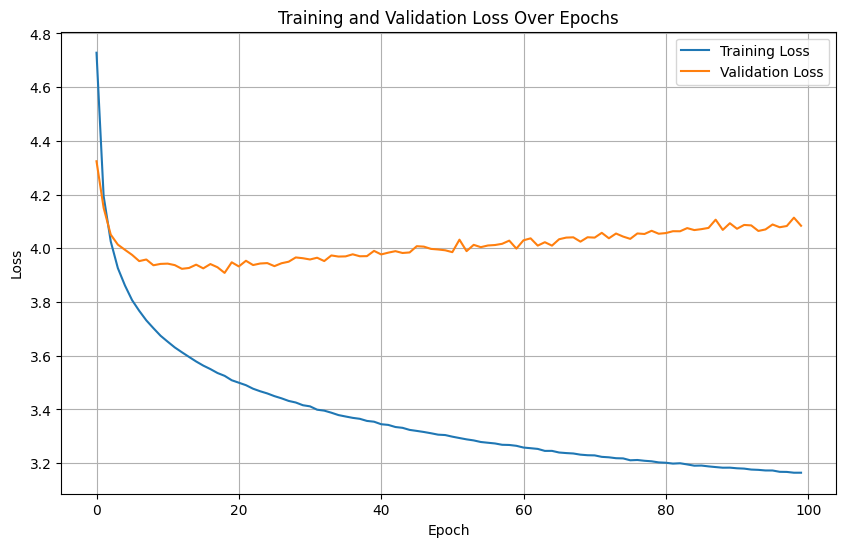

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plotting Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training loss decreases throughout epochs. Validation loss decreases up until ~20th epoch, then it starts increasing. This suggests potential overfitting in the model, where the model learns the patterns in the training sample well but is weaker in generalizing against unseen data.

## Plot attention heatmaps for sample sequences to visualize which tokens attend to which Report Perplexity (PPL) on the validation set as the main evaluation metric - lower is better

Optionally, include sample generations to qualitatively assess model fluency and coherence

In [ ]:
# Report Perplexity (PPL)
# Perplexity is exp(cross_entropy_loss)
last_val_loss = val_losses[-1]
perplexity = torch.exp(torch.tensor(last_val_loss)).item()

print(f"\n{'='*30}")
print(f"Final Validation Loss: {last_val_loss:.4f}")
print(f"Perplexity (PPL) on Validation Set: {perplexity:.2f}")
print(f"{'='*30}")


Final Validation Loss: 4.0838
Perplexity (PPL) on Validation Set: 59.37


A perplexity score is a metric used to evaluate language models, measuring how well a model predicts a sequence of text, A lower score indicates more confident in its predictions, meaning the text is more likely to be generated by model. Our model has a perplexity score of 59.37.


--- Sample 1 ---
Input sequence: sh ow no thing but con f us ion ,
Actual next token: ey


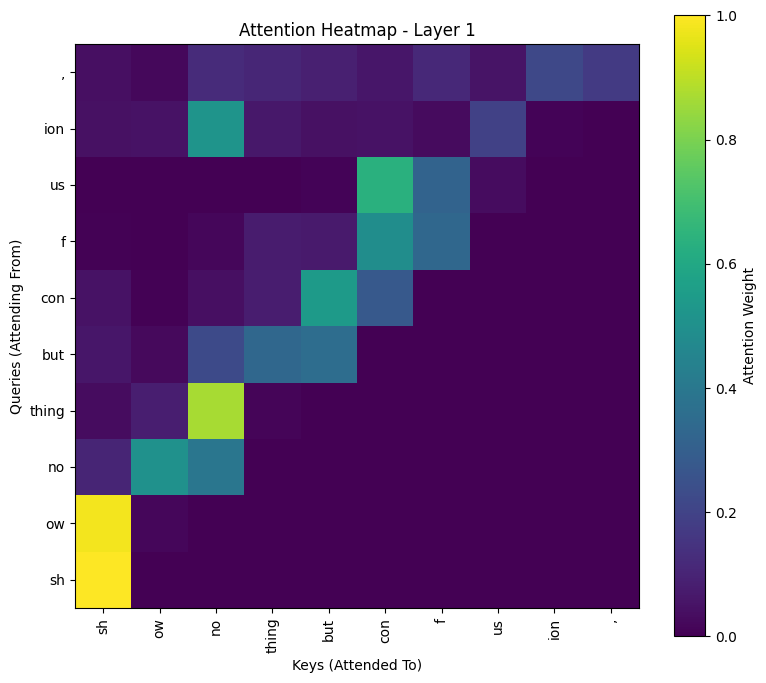

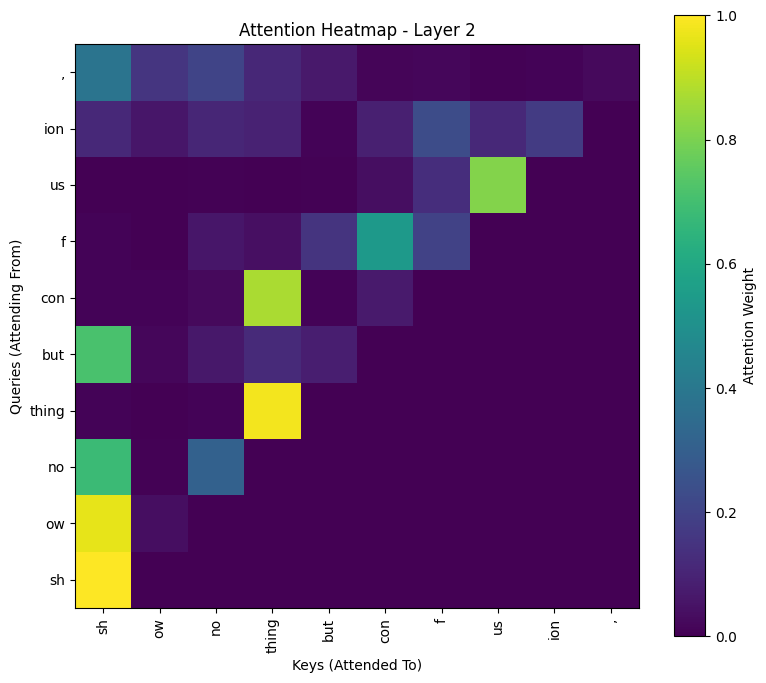


--- Sample 2 ---
Input sequence: as it was w on with blood , lo st be
Actual next token: it


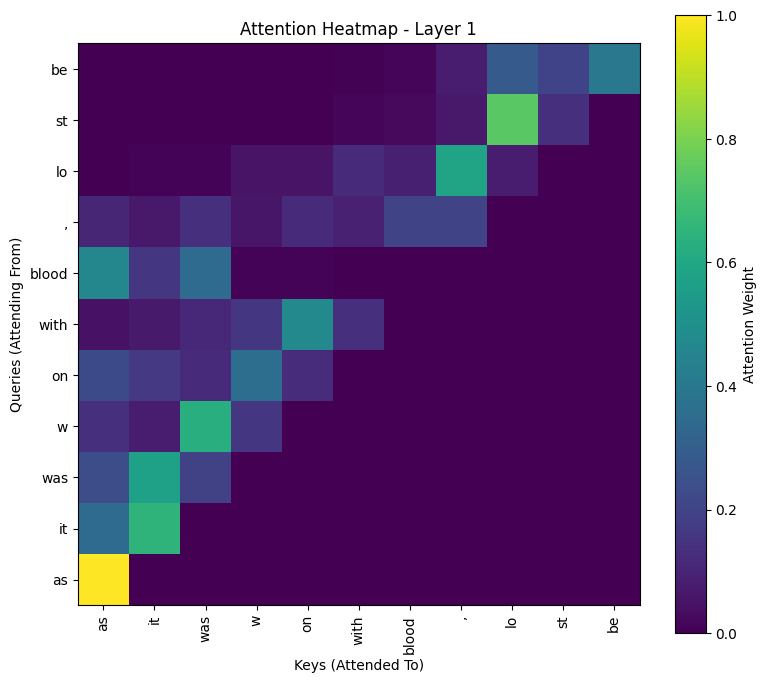

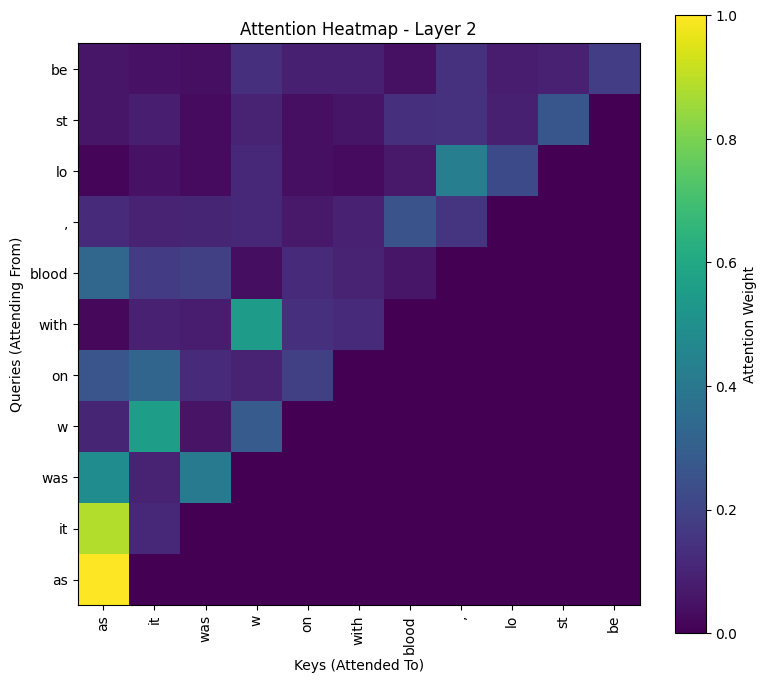

In [ ]:
# Attention Heatmaps for sample sequences

def visualize_attention(model, dataset, tokenizer, id_to_word, pad_token_id, num_examples=2):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for i in range(num_examples):
            # Get a random sample from the dataset
            idx = np.random.randint(0, len(dataset))
            input_ids, target_id = dataset[idx]
            input_ids = input_ids.unsqueeze(0).to(device) # Add batch dim and move to device

            _, all_attn_weights = model(input_ids)

            # Decode input sequence
            input_tokens = [id_to_word.get(token.item(), '<unk>') for token in input_ids[0] if token.item() != pad_token_id]
            target_token = id_to_word.get(target_id.item(), '<unk>')

            print(f"\n--- Sample {i+1} ---")
            print(f"Input sequence: {' '.join(input_tokens)}")
            print(f"Actual next token: {target_token}")

            # Iterate through each layer's attention weights
            for layer_idx, attn_weights in enumerate(all_attn_weights):
                # attn_weights shape: (batch_size, seq_len, seq_len)
                layer_attn = attn_weights[0, :len(input_tokens), :len(input_tokens)].cpu().numpy()

                plt.figure(figsize=(8, 7))
                plt.imshow(layer_attn, cmap='viridis', origin='lower')
                plt.colorbar(label='Attention Weight')
                plt.xticks(range(len(input_tokens)), input_tokens, rotation=90)
                plt.yticks(range(len(input_tokens)), input_tokens)
                plt.xlabel('Keys (Attended To)')
                plt.ylabel('Queries (Attending From)')
                plt.title(f'Attention Heatmap - Layer {layer_idx + 1}')
                plt.tight_layout()
                plt.show()

# Call the function to visualize attention
visualize_attention(model, val_dataset, tokenizer, id_to_word, pad_token_id, num_examples=2)


# Discussion & Reflection



* **Patterns in Attention maps:**
The attention heatmaps show strong attention weights at the diagonal, which indicates that tokens tend to attend most strongly to themselves and the immediate preceding tokens. This is because causal masking is applied, the model cannot look at future tokens and can only use what it has seen so far. Besides that, attention weights in layer 1 are lower compared to attention weights in layer 2, as seen in Sample 2, which indicates a deeper level of pattern recognition.

* **Hyperparameter Impact:**

    * Learning Rate (learning_rate) and Epochs (n_epochs):These two hyperparameters most likely had the greatest impact on model stability. The learning rate was set at 0.001, causing the training loss to decrease steadily. However based on the loss curves, validation loss started to plateau at around the 20th epoch, and ever so increased slightly after that, which suggests potential overfitting. In order to avoid this, we could decrease the number of epochs, or use a learning rate scheduler to adjust the learning rate during training.

    * Model Size: This is a tiny transformer, with only 2 transformer blocks with a hidden size of 128, which limits the model's capacity. While it learned to reduce training loss, its ability to generalize on unseen words is limited. Our model has a final validation loss of 4.0838, and a perplexity score of 59.37 on the validation set. A larger model might achieve a lower perplexity, but it might come at the cost of increased computational resources.

    * Context Length: We set the max context length (max_seq_len) to 15. While this is sufficient for very short word-level predictions, longer sequences would be necessary for capturing more long-range dependencies, potentially leading to better coherence but also at the cost of higher computational cost. This could be a source of improvement, where we can test out a context length of 50.

* **Evolution of Attention:**
As the model train over epochs, attention patterns would likely become sharper and more focused, emphasizing on semantics relevant to the preceding tokens. In the early epochs, the model has not learned specific relationships between tokens. As training progresses, predicting tokens will learn to understand contexts better, which reflects the model's increasing ability to identify meaningful relationships.

* **Role of Positional Encodings:**
Positional encodings are crucial for transformer models because they provide the model with information about the order of tokens in a sequence, which the self-attention mechanism would otherwise miss. Without them, the model cannot differentiate between tokens at different positions, making it impossible to understand the structure or meaning of a sequence. For example, without positional encodings the model would treat "the cat chased the dog" identically to "the dog chased the cat", which are two sentences with completely different meanings.


* **Runtime and Memory:**
This transformer model on the Tiny Shakespeare dataset has a relatively small runtime and memory. The bottlenecks for scaling to larger models would be:
  * Attention mechanism: the attention mechanism that computes the attention scores scales quadratically with sequence length O(seq_len^2, d_model). This is a major bottleneck for very long sequences.
  * Feed-Forward networks: Runtime for feed-forward networks are O(seq_len * d_model * d_ff), which contributes significantly to runtime as model size increases.
  * Number of Layers: Increasing n_layers would directly increase the computational cost and memory required to store activations and gradients during backpropagation.


# AI Tool Usage Disclosure

AI Tools used: Gemini

Gemini was used in four different instances:

generating starter code to import dataset into Google Colab

generating starter code for attention heatmaps

understanding different mechanisms of a transformer affect runtime and memory